In [13]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
import datasets
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")
model = TFAutoModel.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")

# Function to convert text to vectors
def text_to_vector(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=128)
    outputs = model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()

# Load the dataset
dataset = datasets.load_dataset("ta4tsering/Lhasa_kanjur_transcription_datasets")

# Prepare the subset data
subset_dir = "/Selected_LG"  # Update with the path to your folder
image_height, image_width = 64, 2048

def load_image(filename):
    img = Image.open(os.path.join(subset_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((image_width, image_height))
    img = np.array(img) / 255.0
    return img

# Preprocess the data
images, vectors, texts = [], [], []

for example in tqdm(dataset['test']):
    filename = example['filename']
    if os.path.exists(os.path.join(subset_dir, filename)):
        img = load_image(filename)
        vector = text_to_vector(example['label'])
        images.append(img)
        vectors.append(vector)
        texts.append(example['label'])

images = np.array(images).reshape(-1, image_height, image_width, 1)
vectors = np.array(vectors).reshape(-1, 768)  # Adjust based on the actual vector size

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((vectors, images, texts)).batch(32)

# Split dataset into training and validation
train_size = int(0.8 * len(images))
val_size = len(images) - train_size

train_dataset = tf.data.Dataset.from_tensor_slices((vectors[:train_size], images[:train_size], texts[:train_size])).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((vectors[train_size:], images[train_size:], texts[train_size:])).batch(32)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 16640/16640

In [28]:
from tensorflow.keras.layers import Dense, Reshape, Input
from tensorflow.keras.models import Model

def build_autoencoder(input_shape, vector_shape):
    # Encoder
    text_input = Input(shape=vector_shape)
    x = Dense(1024, activation='relu')(text_input)
    x = Dense(512, activation='relu')(x)
    encoded = Dense(256, activation='relu')(x)

    # Decoder
    x = Dense(512, activation='relu')(encoded)
    x = Dense(1024, activation='relu')(x)
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    decoded = Reshape(input_shape)(x)

    # Autoencoder model
    autoencoder = Model(text_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Build the model
input_shape = (image_height, image_width, 1)
vector_shape = (768,)  # Adjust based on the actual vector size

autoencoder = build_autoencoder(input_shape, vector_shape)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 131072)         │   134,348,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 64, 2048, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,449,280 (520.51 MB)

 Trainable params: 136,449,280 (520.51 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
autoencoder.fit(train_dataset.map(lambda v, i, t: (v, i)),
                epochs=100,
                validation_data=val_dataset.map(lambda v, i, t: (v, i)))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1741 - val_loss: 0.1086
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1100 - val_loss: 0.1072
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1085 - val_loss: 0.1070
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1083 - val_loss: 0.1071
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1083 - val_loss: 0.1072
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1084 - val_loss: 0.1071
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1083 - val_loss: 0.1069
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1081 - val_loss: 0.1069
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1081 - val_loss: 0.1070
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1080 - val_loss: 0.1073
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1081 - val_loss: 0.1074
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1639504590>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
སུ་མི་གཟིགས། རྣམ་པར་གནས་པར་ཡང་དག་པར་རྗེས་སུ་མི་གཟིགས། ཡོངས་སུ་གནས་པར་ཡང་དག་པར་རྗེས་སུ་མི་གཟིགས། ཉེ་བར་གནས་པར་ཡང་དག་པར་རྗེས་སུ་


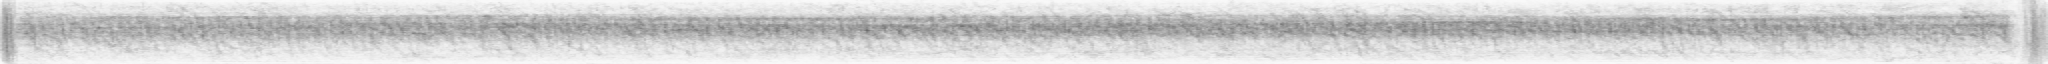

In [31]:
def generate_image(autoencoder, text_vector):
    generated_image = autoencoder.predict(text_vector.reshape(1, -1))
    generated_image = generated_image.reshape(image_height, image_width)
    return (generated_image * 255).astype(np.uint8)

# Example usage with a text from the training set
example_text = texts[1]  # Use the first text from the training set
example_vector = vectors[1]  # Corresponding vector

generated_image = generate_image(autoencoder, example_vector)

# Display the generated image
print(example_text)
Image.fromarray(generated_image).show()